### TEAM ID                         : 5A10 
#### SEMESTER                                : 5
#### DIVISION                        : A  
#### SCHOOL                         : School of Computer Science Engineering
### COURSE                    : Data Mining and Analysis
### COURSE CODE         : 18ECSC301
#### TOPIC ID                         : 5ADMACP16
### PROJECT TITLE             : Cold Start Energy Forecasting
#### PROBLEM STATEMENT : To forecast the consumption of energy for each hour, day and week, given the temperature and building information.
#### TEAM LEADER                : Hemanth H. K. 
#### MEMBERS -                       
####                                            38     Apoorva Hegde    01FE16BCS040
####                                            65     Ganesh Jadhav    01FE16BCS070
####                                            66     Girish Illanad        01FE16BCS071
####                                            67     Hemanth H. K.      01FE16BCS073


### Reviewing the Dataset

   1. **consumption_train.csv**  – This dataset contains data on cold start measurements of building consumption data (in watt-hours) and temperature. The cold start data is provided at an hourly time step over a period of anywhere from 1 day to 2 weeks. Cold start data only comes in full days This is the primary dataset used to train the model.
   
    
   2. **cold_start_test.csv** – This dataset also contains data on cold start measurements of building consumption data (in watt-hours) and temperature, in the same format as consumption_train.csv. These are the series_ids for which final prediction model need to be tested.
   
   
   3. **meta.csv** – This data is supplementary data that can be used to train the model and make the final predictions. It contains information about the holidays (e.g.sunday is holiday.) in both the testing and training datasets.
   
   
   4. **submission_format.csv** -This is the format in which the prediction consumtion values is to be submitted.
   
  ### NOTE 
  - Temperature is in degree celsius.
  - Energy consumption in watt-hours.


In [1]:
#importing the needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline 
from pandas.tools.plotting import autocorrelation_plot
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
from math import sqrt
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_validation import KFold, cross_val_score


Populating the interactive namespace from numpy and matplotlib


C:\Users\Ganesh\Anaconda4\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### DATA PREPROCESSING
#### [1] DATA CLEANING 

In [4]:
#reading the consumption_train.csv 
train_data = pd.read_csv('cold_start_train.csv')
#Extracting the columns from the training data.
train_data = train_data.loc[:,["series_id","timestamp","consumption","temperature"]] 
train_data.head()

,series_id,timestamp,consumption,temperature
0,103088,2014-12-24 00:00:00,101842.233424,NaN
1,103088,2014-12-24 01:00:00,105878.048906,NaN
2,103088,2014-12-24 02:00:00,91619.105008,NaN
3,103088,2014-12-24 03:00:00,94473.706203,NaN
4,103088,2014-12-24 04:00:00,96976.755526,NaN


In [5]:
#reading the  cold_start_test.csv
test_data = pd.read_csv('cold_start_test.csv')
#Extracting the columns from testing data.
test_data = test_data.loc[:,['series_id','timestamp','consumption','temperature']]
test_data.head()

,series_id,timestamp,consumption,temperature
0,102781,27-02-2013 00:00,15295.74039,17.00
1,102781,27-02-2013 01:00,15163.20956,18.25
2,102781,27-02-2013 02:00,15022.26408,18.00
3,102781,27-02-2013 03:00,15370.42046,17.00
4,102781,27-02-2013 04:00,15303.10321,16.90


In [6]:
#reading the  meta.csv
meta_data = pd.read_csv('meta.csv')
meta_data.head()

,series_id,surface,base_temperature,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,friday_is_day_off,saturday_is_day_off,sunday_is_day_off
0,100003,x-large,low,False,False,False,False,False,True,True
1,100004,x-large,low,False,False,False,False,False,True,True
2,100006,x-small,low,False,False,False,False,False,True,True
3,100008,x-small,low,False,False,False,False,False,True,True
4,100010,x-small,low,False,False,False,False,False,True,True


#### [2]DATA INTEGRATION

In [7]:
#concatenating the training and the testing data
train_all = pd.concat((train_data, test_data), axis = 0, ignore_index = True, sort = False)
train_all.head()

,series_id,timestamp,consumption,temperature
0,103088,2014-12-24 00:00:00,101842.233424,NaN
1,103088,2014-12-24 01:00:00,105878.048906,NaN
2,103088,2014-12-24 02:00:00,91619.105008,NaN
3,103088,2014-12-24 03:00:00,94473.706203,NaN
4,103088,2014-12-24 04:00:00,96976.755526,NaN


In [8]:
#checking the size of all the datasets
print(train_data.shape)
print(test_data.shape)
print(train_all.shape)

(509376, 4)
(111984, 4)
(621360, 4)


In [9]:
#finding the number of unique series id's in all datasets
def findUnique(df):
    print(df.nunique())
    print("---------------------------------------------------")
findUnique(train_data)
findUnique(test_data)
findUnique(train_all)
findUnique(meta_data)

series_id         758
timestamp       40392
consumption    276923
temperature     16526
dtype: int64
---------------------------------------------------
series_id        625
timestamp      36648
consumption    81827
temperature     5955
dtype: int64
---------------------------------------------------
series_id        1383
timestamp       77040
consumption    358749
temperature     19736
dtype: int64
---------------------------------------------------
series_id               1383
surface                    7
base_temperature           2
monday_is_day_off          2
tuesday_is_day_off         2
wednesday_is_day_off       2
thursday_is_day_off        2
friday_is_day_off          2
saturday_is_day_off        2
sunday_is_day_off          2
dtype: int64
---------------------------------------------------


#### INFERENCE
#### The combination of the  number of series id's in training and testing is equal to that in meta data. 

In [10]:
#finding the misssing values in all datasets
def findMissingValues(df):
    print(df.isnull().sum()*100/df.shape[0])
    print("---------------------------------------------------")

findMissingValues(train_data)
findMissingValues(test_data)
findMissingValues(train_all)
findMissingValues(meta_data)


series_id       0.000000
timestamp       0.000000
consumption     0.000000
temperature    44.895912
dtype: float64
---------------------------------------------------
series_id       0.000000
timestamp       0.000000
consumption     0.000000
temperature    40.109301
dtype: float64
---------------------------------------------------
series_id       0.00000
timestamp       0.00000
consumption     0.00000
temperature    44.03325
dtype: float64
---------------------------------------------------
series_id               0.0
surface                 0.0
base_temperature        0.0
monday_is_day_off       0.0
tuesday_is_day_off      0.0
wednesday_is_day_off    0.0
thursday_is_day_off     0.0
friday_is_day_off       0.0
saturday_is_day_off     0.0
sunday_is_day_off       0.0
dtype: float64
---------------------------------------------------


#### INFERENCE
#### The missing temperature values in our entire training data is 44% approx. 

In [11]:
#Converting time datatypes to the standard format
print(train_all.dtypes)
train_all['timestamp'] = pd.to_datetime(train_all.timestamp)
print(train_all.dtypes)

series_id        int64
timestamp       object
consumption    float64
temperature    float64
dtype: object
series_id               int64
timestamp      datetime64[ns]
consumption           float64
temperature           float64
dtype: object


#### [3] DATA TRANSFORMATION

In [12]:
#breaking the timestamp into minutes, hours, weekday, day of the year, day of the month, month, and year
def process_time(df):
    
    # Convert timestamp into a pandas datatime object
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')
    
    # Extract units of time from the timestamp
    df['min'] = df.index.minute
    df['hour'] = df.index.hour
    df['wday'] = df.index.dayofweek
    df['mday'] = df.index.day
    df['yday'] = df.index.dayofyear
    df['month'] = df.index.month
    df['year'] = df.index.year
    
    # Create a time of day to represent hours and minutes
    df['time'] = df['hour'] + (df['min'] / 60)
    df = df.drop(columns=['hour', 'min'])
        
    # turn the index into a column
    df = df.reset_index(level=0)
    
    return df
  
# Feature engineering of the time for train and test
train_all = process_time(train_all)
train_all.drop(columns = 'timestamp', inplace = True)
train_all.head()

,series_id,consumption,temperature,wday,mday,yday,month,year,time
0,103088,101842.233424,NaN,2,24,358,12,2014,0.0
1,103088,105878.048906,NaN,2,24,358,12,2014,1.0
2,103088,91619.105008,NaN,2,24,358,12,2014,2.0
3,103088,94473.706203,NaN,2,24,358,12,2014,3.0
4,103088,96976.755526,NaN,2,24,358,12,2014,4.0


In [14]:
train_all['wday'].dtype

dtype('int64')

In [12]:
#he time variables are then converted to cyclical features to preserve the proper relationships between times
def process_time2(df):
    # wday has period of 6
    df['wday_sin'] = np.sin(2 * np.pi * df['wday'] / 6)
    df['wday_cos'] = np.cos(2 * np.pi * df['wday'] / 6)
    
    
    # yday has period of 365
    df['yday_sin'] = np.sin(2 * np.pi * df['yday'] / 365)
    df['yday_cos'] = np.cos(2 * np.pi * df['yday'] / 365)
    
    # month has period of 12
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # time has period of 24
    df['time_sin'] = np.sin(2 * np.pi * df['time'] / 24)
    df['time_cos'] = np.cos(2 * np.pi * df['time'] / 24)

    return df

train = process_time2(train_all)
train.head()

,series_id,consumption,temperature,wday,mday,yday,month,year,time,wday_sin,wday_cos,yday_sin,yday_cos,month_sin,month_cos,time_sin,time_cos
0,103088,101842.233424,NaN,2,24,358,12,2014,0.0,0.866025,-0.5,-0.120208,0.992749,-2.449294e-16,1.0,0.000000,1.000000
1,103088,105878.048906,NaN,2,24,358,12,2014,1.0,0.866025,-0.5,-0.120208,0.992749,-2.449294e-16,1.0,0.258819,0.965926
2,103088,91619.105008,NaN,2,24,358,12,2014,2.0,0.866025,-0.5,-0.120208,0.992749,-2.449294e-16,1.0,0.500000,0.866025
3,103088,94473.706203,NaN,2,24,358,12,2014,3.0,0.866025,-0.5,-0.120208,0.992749,-2.449294e-16,1.0,0.707107,0.707107
4,103088,96976.755526,NaN,2,24,358,12,2014,4.0,0.866025,-0.5,-0.120208,0.992749,-2.449294e-16,1.0,0.866025,0.500000


In [13]:
## Create a new dataframe for the series id from meta data
id_list = set(meta_data['series_id'])
all_meta = pd.DataFrame(columns=['series_id', 'wday', 'off'])
all_meta=all_meta.astype(int)
len(id_list)

1383

In [14]:
# Iterate through each series id and find days off
for id in id_list:
    # Extract the metadata information for the series id
    meta_slice = meta_data.ix[meta_data['series_id'] == id]
    
    # Create a new dataframe for the series id
    building_meta = pd.DataFrame(columns=['series_id', 'wday', 'off'],
                            index = [0, 1, 2, 3, 4, 5, 6])
    
    building_meta['wday'] = [0, 1, 2, 3, 4, 5, 6]
    building_meta['series_id'] = id
    
    # Record the days off
    building_meta.ix[0, 'off'] = float(meta_slice['monday_is_day_off'])
    building_meta.ix[1, 'off'] = float(meta_slice['tuesday_is_day_off'])
    building_meta.ix[2, 'off'] = float(meta_slice['wednesday_is_day_off'])
    building_meta.ix[3, 'off'] = float(meta_slice['thursday_is_day_off'])
    building_meta.ix[4, 'off'] = float(meta_slice['friday_is_day_off'])
    building_meta.ix[5, 'off'] = float(meta_slice['saturday_is_day_off'])
    building_meta.ix[6, 'off'] = float(meta_slice['sunday_is_day_off'])
    
    # Append the resulting dataframe to all site dataframe
    all_meta = all_meta.append(building_meta) 
    
# merging(left join) back to the orignal meta data
train = train_all.merge(all_meta, how = 'left', on = ['series_id','wday'])
train.head()

C:\Users\Ganesh\Anaconda4\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
C:\Users\Ganesh\Anaconda4\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\Users\Ganesh\Anaconda4\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app
C:\Users\Ganesh\Anaconda4\lib

,series_id,consumption,temperature,wday,mday,yday,month,year,time,wday_sin,wday_cos,yday_sin,yday_cos,month_sin,month_cos,time_sin,time_cos,off
0,103088,101842.233424,NaN,2,24,358,12,2014,0.0,0.866025,-0.5,-0.120208,0.992749,-2.449294e-16,1.0,0.000000,1.000000,0
1,103088,105878.048906,NaN,2,24,358,12,2014,1.0,0.866025,-0.5,-0.120208,0.992749,-2.449294e-16,1.0,0.258819,0.965926,0
2,103088,91619.105008,NaN,2,24,358,12,2014,2.0,0.866025,-0.5,-0.120208,0.992749,-2.449294e-16,1.0,0.500000,0.866025,0
3,103088,94473.706203,NaN,2,24,358,12,2014,3.0,0.866025,-0.5,-0.120208,0.992749,-2.449294e-16,1.0,0.707107,0.707107,0
4,103088,96976.755526,NaN,2,24,358,12,2014,4.0,0.866025,-0.5,-0.120208,0.992749,-2.449294e-16,1.0,0.866025,0.500000,0


In [16]:
#preparing to merge the training data and testing with meta
left = train
right  = meta_data.loc[:,["series_id","surface","base_temperature"]] 
print(left.head())
print(right.head())
print(left.shape)
print(right.shape)


   series_id    consumption  temperature  wday  mday  yday  month  year  time  \
0     103088  101842.233424          NaN     2    24   358     12  2014   0.0   
1     103088  105878.048906          NaN     2    24   358     12  2014   1.0   
2     103088   91619.105008          NaN     2    24   358     12  2014   2.0   
3     103088   94473.706203          NaN     2    24   358     12  2014   3.0   
4     103088   96976.755526          NaN     2    24   358     12  2014   4.0   

   wday_sin  wday_cos  yday_sin  yday_cos     month_sin  month_cos  time_sin  \
0  0.866025      -0.5 -0.120208  0.992749 -2.449294e-16        1.0  0.000000   
1  0.866025      -0.5 -0.120208  0.992749 -2.449294e-16        1.0  0.258819   
2  0.866025      -0.5 -0.120208  0.992749 -2.449294e-16        1.0  0.500000   
3  0.866025      -0.5 -0.120208  0.992749 -2.449294e-16        1.0  0.707107   
4  0.866025      -0.5 -0.120208  0.992749 -2.449294e-16        1.0  0.866025   

   time_cos  off  
0  1.000000  

In [17]:
#checking the  training data after merging with train, test with meta data.
merged_data = pd.merge(left,right,on = 'series_id')
merged_data.head()

,series_id,consumption,temperature,wday,mday,yday,month,year,time,wday_sin,wday_cos,yday_sin,yday_cos,month_sin,month_cos,time_sin,time_cos,off,surface,base_temperature
0,103088,101842.233424,NaN,2,24,358,12,2014,0.0,0.866025,-0.5,-0.120208,0.992749,-2.449294e-16,1.0,0.000000,1.000000,0,x-small,low
1,103088,105878.048906,NaN,2,24,358,12,2014,1.0,0.866025,-0.5,-0.120208,0.992749,-2.449294e-16,1.0,0.258819,0.965926,0,x-small,low
2,103088,91619.105008,NaN,2,24,358,12,2014,2.0,0.866025,-0.5,-0.120208,0.992749,-2.449294e-16,1.0,0.500000,0.866025,0,x-small,low
3,103088,94473.706203,NaN,2,24,358,12,2014,3.0,0.866025,-0.5,-0.120208,0.992749,-2.449294e-16,1.0,0.707107,0.707107,0,x-small,low
4,103088,96976.755526,NaN,2,24,358,12,2014,4.0,0.866025,-0.5,-0.120208,0.992749,-2.449294e-16,1.0,0.866025,0.500000,0,x-small,low


In [20]:
#Comparing the unique attributes
findUnique(merged_data)

series_id             1383
consumption         358749
temperature          19736
wday                     7
mday                    31
yday                   366
month                   12
year                     6
time                    24
wday_sin                 7
wday_cos                 5
yday_sin               366
yday_cos               338
month_sin               11
month_cos               11
time_sin                21
time_cos                22
off                      2
surface                  7
base_temperature         2
dtype: int64
---------------------------------------------------


In [21]:
#working with the categorical data
print(merged_data.surface.value_counts())
print(merged_data.base_temperature.value_counts())

x-large     175104
x-small     141408
medium       73440
xx-small     73344
small        62928
xx-large     48672
large        46464
Name: surface, dtype: int64
low     605520
high     15840
Name: base_temperature, dtype: int64


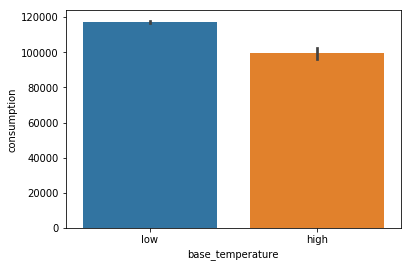

In [22]:
#understanding the relation between base temperature and label
g = sns.barplot(x="base_temperature",y="consumption",data=merged_data)
g = g.set_ylabel("consumption")

#### INFERENCE
#### The high/low temperature in the base temperature doesnt imply any relation with target

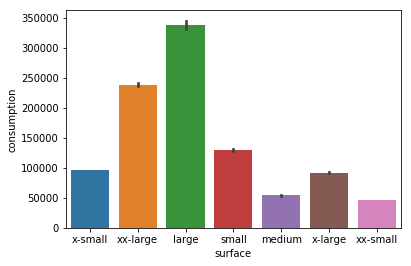

In [23]:
#understanding the relation between surface and label
g= sns.barplot(x="surface",y="consumption",data=merged_data)
g = g.set_ylabel("consumption")

#### INFERENCE
#### The surface (buildings) marked - 'large' consume the most energy 

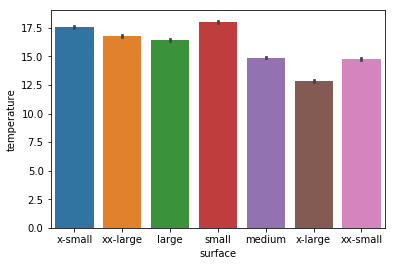

In [26]:
#finding the relation between surface and temperature
g = sns.barplot(x="surface",y="temperature",data=merged_data)
g = g.set_ylabel("temperature")

#### INFERENCE
#### The smaller the  surface has higher the temperature 

In [24]:
#defining functions to find maximum and minimum for attributes in dataFrame
d = merged_data
def findMinMax(df,col):
    print("Extremes for ",col )
    print( df.groupby(col).apply(lambda x: x.temperature[x.temperature.idxmax()]))
    print(df.groupby(col).apply(lambda x: x.temperature[x.temperature.idxmin()]))
def findMinMaxConsumption(df,col):
    print("Extremes for ",col )
    print( df.groupby(col).apply(lambda x: x.consumption[x.consumption.idxmax()]));
    print(df.groupby(col).apply(lambda x: x.consumption[x.consumption.idxmin()]));

In [25]:
#finding maximum and minimum for surface and base temperature in dataFrame
a1 = findMinMax(d, "surface")
a2 = findMinMax(d, "base_temperature")
a3 = findMinMaxConsumption(d, "surface")
a4 = findMinMaxConsumption(d, "base_temperature")

Extremes for  surface
surface
large       41.975000
medium      40.000000
small       41.050000
x-large     39.333333
x-small     42.000000
xx-large    44.350000
xx-small    40.255556
dtype: float64
surface
large      -13.177778
medium     -13.350000
small       -8.200000
x-large    -13.466667
x-small     -7.500000
xx-large    -4.000000
xx-small   -11.600000
dtype: float64
Extremes for  base_temperature
base_temperature
high    41.025
low     44.350
dtype: float64
base_temperature
high    -2.000000
low    -13.466667
dtype: float64
Extremes for  surface
surface
large       5.366167e+06
medium      9.682094e+05
small       1.228276e+06
x-large     2.232319e+06
x-small     7.531038e+05
xx-large    2.544710e+06
xx-small    7.640333e+05
dtype: float64
surface
large       12.759773
medium      21.262327
small       64.440046
x-large      0.000000
x-small      0.000000
xx-large     0.000000
xx-small     0.000000
dtype: float64
Extremes for  base_temperature
base_temperature
high    2544710.10

In [27]:
#one hot encoding the surface column
def convert_to_binary(df, column_to_convert):
    categories = list(df[column_to_convert].drop_duplicates())

    for category in categories:
        cat_name = str(category).replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_").replace("-", "").lower()
        col_name = column_to_convert[:5] + '_' + cat_name[:10]
        df[col_name] = 0
        df.loc[(df[column_to_convert] == category), col_name] = 1

    return df
columns_to_convert = ['surface']

for column in columns_to_convert:
    merged_data = convert_to_binary(df=merged_data, column_to_convert=column)
    merged_data.drop(column, axis=1, inplace=True)
merged_data.head()

,series_id,consumption,temperature,wday,mday,yday,month,year,time,wday_sin,...,time_cos,off,base_temperature,surfa_xsmall,surfa_xxlarge,surfa_large,surfa_small,surfa_medium,surfa_xlarge,surfa_xxsmall
0,103088,101842.233424,NaN,2,24,358,12,2014,0.0,0.866025,...,1.000000,0,low,1,0,0,0,0,0,0
1,103088,105878.048906,NaN,2,24,358,12,2014,1.0,0.866025,...,0.965926,0,low,1,0,0,0,0,0,0
2,103088,91619.105008,NaN,2,24,358,12,2014,2.0,0.866025,...,0.866025,0,low,1,0,0,0,0,0,0
3,103088,94473.706203,NaN,2,24,358,12,2014,3.0,0.866025,...,0.707107,0,low,1,0,0,0,0,0,0
4,103088,96976.755526,NaN,2,24,358,12,2014,4.0,0.866025,...,0.500000,0,low,1,0,0,0,0,0,0


In [28]:
#mapping the values in base temperature to 0 and 1(high) and creating a new attribute base num
merged_data['base_num'] = merged_data.base_temperature.map({'high':1, 'low':0});
#dropping the base temperature since its corresponding values are already in base-num
merged_data.drop(columns = 'base_temperature', inplace = True)
print(merged_data.shape)
merged_data.head()


(621360, 26)


,series_id,consumption,temperature,wday,mday,yday,month,year,time,wday_sin,...,time_cos,off,surfa_xsmall,surfa_xxlarge,surfa_large,surfa_small,surfa_medium,surfa_xlarge,surfa_xxsmall,base_num
0,103088,101842.233424,NaN,2,24,358,12,2014,0.0,0.866025,...,1.000000,0,1,0,0,0,0,0,0,0
1,103088,105878.048906,NaN,2,24,358,12,2014,1.0,0.866025,...,0.965926,0,1,0,0,0,0,0,0,0
2,103088,91619.105008,NaN,2,24,358,12,2014,2.0,0.866025,...,0.866025,0,1,0,0,0,0,0,0,0
3,103088,94473.706203,NaN,2,24,358,12,2014,3.0,0.866025,...,0.707107,0,1,0,0,0,0,0,0,0
4,103088,96976.755526,NaN,2,24,358,12,2014,4.0,0.866025,...,0.500000,0,1,0,0,0,0,0,0,0


#### INFERENCE
#### The combination of all data sets leaves us with a total of 26 attributes.. 

#### [4]OUTLIER CHECK

In [30]:
#Finding the outliers in training data.
#For temperature:
print('Maximum temperature in training data:',merged_data.temperature.max())
print('Minimum temperature in training data":',merged_data.temperature.min())
print('\n')
#For consumption:
print('Maximum consumption in training data:',merged_data.consumption.max())
print('Maximum consumption in training data:',merged_data.consumption.min())
print('\n')
x = 0.80*merged_data.consumption.max()
print("Max: ", x)
print('Number of tuples with greater than 80% of max consumption: ',merged_data[merged_data.consumption>x]["consumption"].count()) #Considering values 80% as threshold.
df = merged_data
train_high = df[df.consumption>x]["consumption"]


Maximum temperature in training data: 44.35
Minimum temperature in training data": -13.4666666667


Maximum consumption in training data: 5366166.585
Maximum consumption in training data: 0.0


Max:  4292933.268
Number of tuples with greater than 80% of max consumption:  1116


### Inference: 
Given the temperature's range, its neiter too hot nor too cold to be termed as outliers. Hence we find no outliers in temperature.<br> 
Given the consumption's range, most of the id's(buildings) i.e atleast 100 have consumption more than normal, but they might be industries or factories which might consume more power . Hence we find no outliers in consumption.


#### [5]HANDLING MISSING DATA

In [29]:
#finding the missing values
merged_data.isnull().sum()*100/merged_data.shape[0]

series_id         0.00000
consumption       0.00000
temperature      44.03325
wday              0.00000
mday              0.00000
yday              0.00000
month             0.00000
year              0.00000
time              0.00000
wday_sin          0.00000
wday_cos          0.00000
yday_sin          0.00000
yday_cos          0.00000
month_sin         0.00000
month_cos         0.00000
time_sin          0.00000
time_cos          0.00000
off               0.00000
surfa_xsmall      0.00000
surfa_xxlarge     0.00000
surfa_large       0.00000
surfa_small       0.00000
surfa_medium      0.00000
surfa_xlarge      0.00000
surfa_xxsmall     0.00000
base_num          0.00000
dtype: float64

In [32]:
#savaing the dataframe before experimenting on it.
train = merged_data

In [34]:
#grouping the series id, month and year and fill missing temperature
train["temperature"] = train.groupby(["series_id","month","year"]).temperature.transform(lambda x: x.fillna(x.mean()))
train.isnull().sum()*100/train.shape[0]

series_id         0.000000
consumption       0.000000
temperature      34.495944
wday              0.000000
mday              0.000000
yday              0.000000
month             0.000000
year              0.000000
time              0.000000
wday_sin          0.000000
wday_cos          0.000000
yday_sin          0.000000
yday_cos          0.000000
month_sin         0.000000
month_cos         0.000000
time_sin          0.000000
time_cos          0.000000
off               0.000000
surfa_xsmall      0.000000
surfa_xxlarge     0.000000
surfa_large       0.000000
surfa_small       0.000000
surfa_medium      0.000000
surfa_xlarge      0.000000
surfa_xxsmall     0.000000
base_num          0.000000
dtype: float64

In [35]:
#grouping the series id and year and fill missing temperature with mean
train["temperature"] = train.groupby(["series_id","year"]).temperature.transform(lambda x: x.fillna(x.mean()))
train.isnull().sum()*100/train.shape[0]

series_id         0.000000
consumption       0.000000
temperature      33.661645
wday              0.000000
mday              0.000000
yday              0.000000
month             0.000000
year              0.000000
time              0.000000
wday_sin          0.000000
wday_cos          0.000000
yday_sin          0.000000
yday_cos          0.000000
month_sin         0.000000
month_cos         0.000000
time_sin          0.000000
time_cos          0.000000
off               0.000000
surfa_xsmall      0.000000
surfa_xxlarge     0.000000
surfa_large       0.000000
surfa_small       0.000000
surfa_medium      0.000000
surfa_xlarge      0.000000
surfa_xxsmall     0.000000
base_num          0.000000
dtype: float64

In [36]:
#grouping the series id and fill missing temperature with mean
train["temperature"] = train.groupby(["series_id"]).temperature.transform(lambda x: x.fillna(x.mean()))
train.isnull().sum()*100/train.shape[0]

series_id         0.000000
consumption       0.000000
temperature      33.588258
wday              0.000000
mday              0.000000
yday              0.000000
month             0.000000
year              0.000000
time              0.000000
wday_sin          0.000000
wday_cos          0.000000
yday_sin          0.000000
yday_cos          0.000000
month_sin         0.000000
month_cos         0.000000
time_sin          0.000000
time_cos          0.000000
off               0.000000
surfa_xsmall      0.000000
surfa_xxlarge     0.000000
surfa_large       0.000000
surfa_small       0.000000
surfa_medium      0.000000
surfa_xlarge      0.000000
surfa_xxsmall     0.000000
base_num          0.000000
dtype: float64

### Inference: 
#### The total missing values after filling via groupby is still ~34%. We shall make use of machine learning to fill in the rest.

In [37]:
#Seperating the the tuples with missing temperature 
data_null=train[pd.isnull(train['temperature'])]
data_null.head()

,series_id,consumption,temperature,wday,mday,yday,month,year,time,wday_sin,...,time_cos,off,surfa_xsmall,surfa_xxlarge,surfa_large,surfa_small,surfa_medium,surfa_xlarge,surfa_xxsmall,base_num
8064,102652,410495.401672,NaN,2,2,214,8,2017,0.0,0.866025,...,1.000000,0,1,0,0,0,0,0,0,0
8065,102652,417329.570049,NaN,2,2,214,8,2017,1.0,0.866025,...,0.965926,0,1,0,0,0,0,0,0,0
8066,102652,403820.603476,NaN,2,2,214,8,2017,2.0,0.866025,...,0.866025,0,1,0,0,0,0,0,0,0
8067,102652,393883.403916,NaN,2,2,214,8,2017,3.0,0.866025,...,0.707107,0,1,0,0,0,0,0,0,0
8068,102652,402465.956933,NaN,2,2,214,8,2017,4.0,0.866025,...,0.500000,0,1,0,0,0,0,0,0,0


In [38]:
#seperated dataframe has no values for temperature column
data_null.isnull().sum()*100/data_null.shape[0]

series_id          0.0
consumption        0.0
temperature      100.0
wday               0.0
mday               0.0
yday               0.0
month              0.0
year               0.0
time               0.0
wday_sin           0.0
wday_cos           0.0
yday_sin           0.0
yday_cos           0.0
month_sin          0.0
month_cos          0.0
time_sin           0.0
time_cos           0.0
off                0.0
surfa_xsmall       0.0
surfa_xxlarge      0.0
surfa_large        0.0
surfa_small        0.0
surfa_medium       0.0
surfa_xlarge       0.0
surfa_xxsmall      0.0
base_num           0.0
dtype: float64

In [39]:
#dropping the rows in the training data that were missing  
train.dropna(inplace=True) 

In [41]:
#extracting required features that'll be needed to fill missing temperature(acts as a label here now)
x= train.loc[:,['series_id','base_num','wday_sin','wday_cos','yday_sin','wday_cos','month_sin','month_cos','time_sin','time_cos']]
print(x.head())
x1= data_null.loc[:,['series_id','base_num','wday_sin','wday_cos','yday_sin','wday_cos','month_sin','month_cos','time_sin','time_cos']]
print(x1.head())

   series_id  base_num  wday_sin  wday_cos  yday_sin  wday_cos     month_sin  \
0     103088         0  0.866025      -0.5 -0.120208      -0.5 -2.449294e-16   
1     103088         0  0.866025      -0.5 -0.120208      -0.5 -2.449294e-16   
2     103088         0  0.866025      -0.5 -0.120208      -0.5 -2.449294e-16   
3     103088         0  0.866025      -0.5 -0.120208      -0.5 -2.449294e-16   
4     103088         0  0.866025      -0.5 -0.120208      -0.5 -2.449294e-16   

   month_cos  time_sin  time_cos  
0        1.0  0.000000  1.000000  
1        1.0  0.258819  0.965926  
2        1.0  0.500000  0.866025  
3        1.0  0.707107  0.707107  
4        1.0  0.866025  0.500000  
      series_id  base_num  wday_sin  wday_cos  yday_sin  wday_cos  month_sin  \
8064     102652         0  0.866025      -0.5 -0.516062      -0.5  -0.866025   
8065     102652         0  0.866025      -0.5 -0.516062      -0.5  -0.866025   
8066     102652         0  0.866025      -0.5 -0.516062      -0.5  -0

In [42]:
#taking the label.
y=train[['temperature']]
print(y.head())
y1=data_null[['temperature']]
print(y1.head())


   temperature
0    -6.105093
1    -6.105093
2    -6.105093
3    -6.105093
4    -6.105093
      temperature
8064          NaN
8065          NaN
8066          NaN
8067          NaN
8068          NaN


### Analysis: 
Given the data is non linear, linear models will not fit properly.Hence using ensemble methods will be appropriate.
<br>Of all ensemble methods randomforestregressor gave best results. We proceed with the same model to fill temperature

In [43]:
#Training model to fill the missing temperature values considering other features.
lr = RandomForestRegressor(max_depth=30 , random_state=0,n_estimators=100)   
lr.fit(x, y)

y0_predict=lr.predict(x1)
print(y0_predict)

C:\Users\Ganesh\Anaconda4\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


[ 19.77632294  19.59812204  18.08595352 ...,  14.60516667  14.01706771
  13.58725   ]


In [44]:
#dropping the temperature column so to add the last predicted one.
data_null.drop('temperature',axis=1, inplace = True)
data_null.head()
data_null.shape

C:\Users\Ganesh\Anaconda4\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(208704, 25)

In [45]:
#Adding predicted temperature to the dataframe
data_null['temperature']=y0_predict
data_null.head()

C:\Users\Ganesh\Anaconda4\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,series_id,consumption,wday,mday,yday,month,year,time,wday_sin,wday_cos,...,off,surfa_xsmall,surfa_xxlarge,surfa_large,surfa_small,surfa_medium,surfa_xlarge,surfa_xxsmall,base_num,temperature
8064,102652,410495.401672,2,2,214,8,2017,0.0,0.866025,-0.5,...,0,1,0,0,0,0,0,0,0,19.776323
8065,102652,417329.570049,2,2,214,8,2017,1.0,0.866025,-0.5,...,0,1,0,0,0,0,0,0,0,19.598122
8066,102652,403820.603476,2,2,214,8,2017,2.0,0.866025,-0.5,...,0,1,0,0,0,0,0,0,0,18.085954
8067,102652,393883.403916,2,2,214,8,2017,3.0,0.866025,-0.5,...,0,1,0,0,0,0,0,0,0,17.869810
8068,102652,402465.956933,2,2,214,8,2017,4.0,0.866025,-0.5,...,0,1,0,0,0,0,0,0,0,17.679088


In [46]:
frames = [train,data_null]

In [47]:
#merging back the filled temperature back to the original training dataframe
data = pd.concat(frames)

C:\Users\Ganesh\Anaconda4\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [48]:
#finding the size of dataframe after feature engineering
data.shape

(621360, 26)

In [33]:
#finding the correlation between the attributes
merged_data.corr()

,series_id,consumption,temperature,wday,mday,yday,month,year,time,wday_sin,...,time_cos,off,surfa_xsmall,surfa_xxlarge,surfa_large,surfa_small,surfa_medium,surfa_xlarge,surfa_xxsmall,base_num
series_id,1.000000e+00,-0.000639,-0.091192,-1.257026e-03,-2.034366e-03,-3.429169e-02,-3.447475e-02,3.963661e-02,-3.270515e-21,1.030816e-03,...,-1.130334e-18,3.165455e-04,-6.291035e-03,-2.846168e-03,3.271743e-02,2.190540e-02,1.718149e-02,-5.235427e-03,-4.650056e-02,-2.984938e-02
consumption,-6.391909e-04,1.000000,0.077415,-4.592265e-02,1.338231e-02,2.927982e-03,1.819251e-03,-2.727409e-02,2.971470e-02,2.712351e-02,...,-8.274612e-02,-3.304358e-02,-4.130640e-02,1.318064e-01,2.343532e-01,1.656057e-02,-8.554870e-02,-5.850657e-02,-9.544778e-02,-1.050606e-02
temperature,-9.119163e-02,0.077415,1.000000,3.652386e-04,1.898197e-02,1.621315e-01,1.631686e-01,1.232972e-01,1.674169e-01,1.817601e-04,...,-1.820528e-01,-3.549405e-02,9.624663e-02,5.002577e-02,4.435886e-02,1.176139e-01,-2.169338e-02,-1.845113e-01,-2.097269e-02,1.122648e-01
wday,-1.257026e-03,-0.045923,0.000365,1.000000e+00,-1.622656e-03,-2.826339e-03,-2.696310e-03,-4.198767e-03,-1.207507e-17,-5.672920e-01,...,2.240227e-17,7.330647e-01,-9.761945e-04,1.935666e-03,3.300063e-03,1.821955e-03,2.196944e-04,-1.480829e-03,-2.892378e-03,1.203050e-03
mday,-2.034366e-03,0.013382,0.018982,-1.622656e-03,1.000000e+00,8.179801e-02,-5.023940e-03,-1.931295e-02,5.060603e-18,-4.707085e-04,...,-3.738570e-18,-1.765228e-03,1.409025e-02,-1.493776e-03,1.420118e-03,1.543185e-03,-4.661089e-03,-6.966646e-03,-5.288718e-03,-2.212390e-03
yday,-3.429169e-02,0.002928,0.162132,-2.826339e-03,8.179801e-02,1.000000e+00,9.961983e-01,-7.328397e-02,3.420181e-18,8.345234e-04,...,6.528125e-19,-1.028646e-02,-5.426739e-02,3.453690e-02,5.496294e-03,3.431943e-02,2.346160e-02,-2.229800e-02,1.280139e-02,2.359749e-02
month,-3.447475e-02,0.001819,0.163169,-2.696310e-03,-5.023940e-03,9.961983e-01,1.000000e+00,-7.141989e-02,4.980083e-22,8.890569e-04,...,5.574823e-18,-1.039568e-02,-5.567349e-02,3.492369e-02,5.234006e-03,3.499188e-02,2.386286e-02,-2.222809e-02,1.339252e-02,2.412804e-02
year,3.963661e-02,-0.027274,0.123297,-4.198767e-03,-1.931295e-02,-7.328397e-02,-7.141989e-02,1.000000e+00,0.000000e+00,2.028034e-03,...,-1.462975e-17,-4.810369e-02,1.310977e-01,2.391614e-02,4.516209e-03,2.086779e-01,6.775359e-02,-3.671086e-01,5.499994e-02,6.979611e-02
time,-3.270515e-21,0.029715,0.167417,-1.207507e-17,5.060603e-18,3.420181e-18,4.980083e-22,0.000000e+00,1.000000e+00,-1.849568e-17,...,-1.021508e-01,-9.398491e-22,1.231292e-21,9.318372e-21,5.102903e-21,1.711157e-22,-2.558539e-21,-6.885066e-22,0.000000e+00,7.451376e-21
wday_sin,1.030816e-03,0.027124,0.000182,-5.672920e-01,-4.707085e-04,8.345234e-04,8.890569e-04,2.028034e-03,-1.849568e-17,1.000000e+00,...,1.126166e-17,-3.869291e-01,-1.444875e-03,-7.547434e-04,-1.635346e-03,-1.021220e-03,1.759270e-03,1.369408e-03,1.124440e-03,-2.386275e-04


In [50]:
#dropping the attributes that are already converted into cyclic.
df =data.drop(columns=['month','mday','wday','yday','time'])
df.columns

Index(['base_num', 'consumption', 'month_cos', 'month_sin', 'off', 'series_id',
       'surfa_large', 'surfa_medium', 'surfa_small', 'surfa_xlarge',
       'surfa_xsmall', 'surfa_xxlarge', 'surfa_xxsmall', 'temperature',
       'time_cos', 'time_sin', 'wday_cos', 'wday_sin', 'yday_cos', 'yday_sin',
       'year'],
      dtype='object')

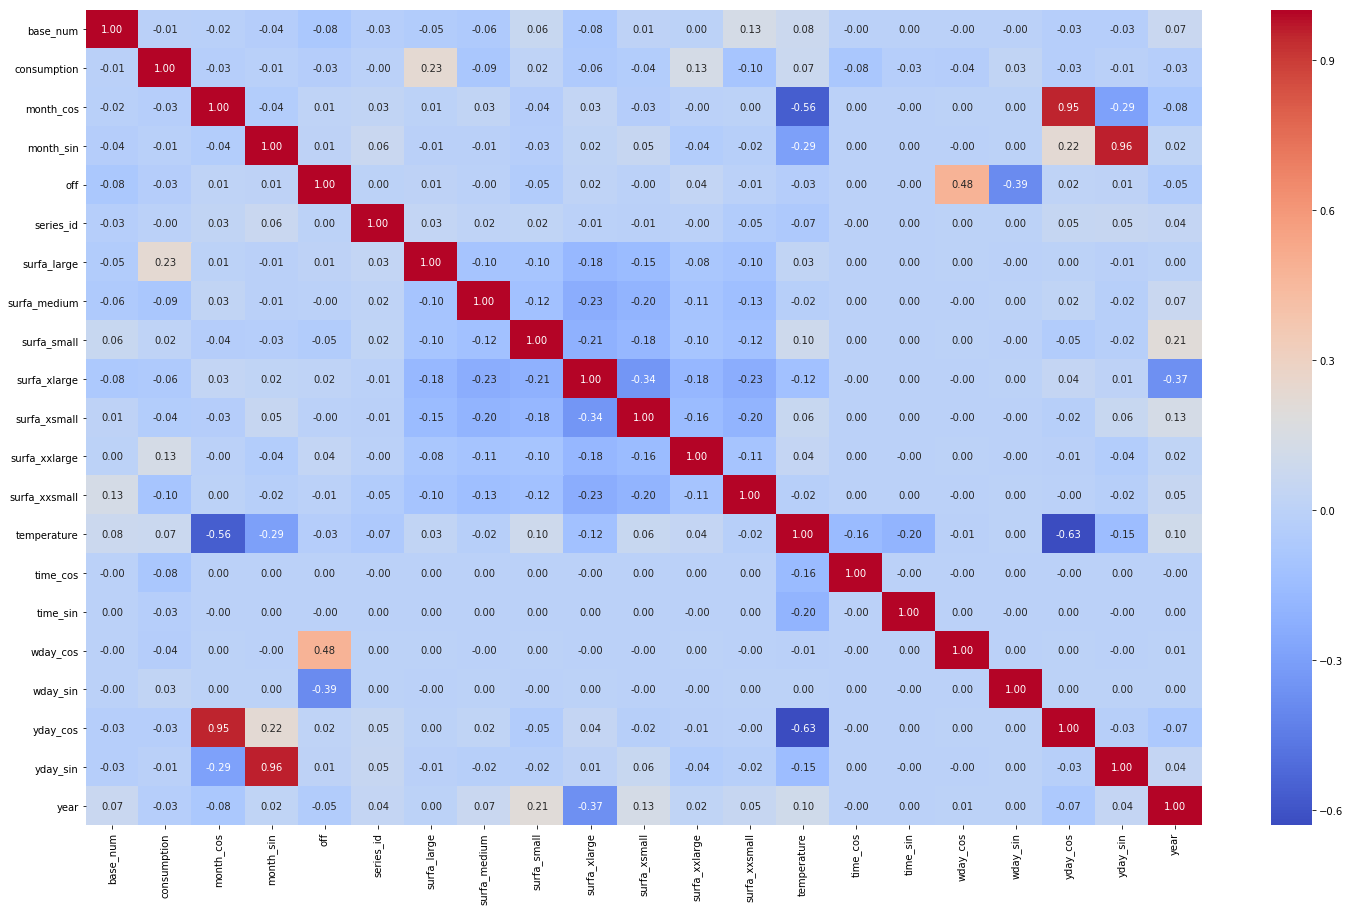

In [51]:
# Correlation matrix between numerical values  
plt.figure(figsize = (25,15))
g = sns.heatmap(df.corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

In [52]:
#finding the correlation with target
df.corr()['consumption']

base_num        -0.010506
consumption      1.000000
month_cos       -0.025358
month_sin       -0.012999
off             -0.033044
series_id       -0.000639
surfa_large      0.234353
surfa_medium    -0.085549
surfa_small      0.016561
surfa_xlarge    -0.058507
surfa_xsmall    -0.041306
surfa_xxlarge    0.131806
surfa_xxsmall   -0.095448
temperature      0.070875
time_cos        -0.082746
time_sin        -0.026189
wday_cos        -0.036897
wday_sin         0.027124
yday_cos        -0.029068
yday_sin        -0.009875
year            -0.027274
Name: consumption, dtype: float64

In [53]:
#performing the chisquare tests 
lm1 = smf.ols(formula='consumption ~ base_num+month_cos+month_sin+off+series_id+surfa_large+surfa_medium+surfa_small+surfa_xlarge+surfa_xsmall+surfa_xxlarge+surfa_xxsmall+temperature+time_cos+time_sin+wday_cos+wday_sin+yday_cos+yday_sin+year',data=df).fit()

# print the coefficients
lm1.params
lm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            consumption   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     3580.
Date:                Mon, 26 Nov 2018   Prob (F-statistic):               0.00
Time:                        18:42:44   Log-Likelihood:            -8.6180e+06
No. Observations:              621360   AIC:                         1.724e+07
Df Residuals:                  621340   BIC:                         1.724e+07
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.068e+07   5.88e+05     35.152      0.000    1.95e+07    2.18e+07
base_num       -237.8168   2103.547     -0.113      0.910   -4360.700    3885.067
month_cos     -6893.3860   3030.532     -2.275      0.023   -1.28e+04    -953.640
month_sin      5.499e+04   3050.468     18.027      0.000     4.9e+04     6.1e+04
off           -1.134e+04    943.645    -12.015      0.000   -1.32e+04   -9488.725
series_id        -1.7912      0.315     -5.682      0.000      -2.409      -1.173
surfa_large     3.15e+06    8.4e+04     37.484      0.000    2.99e+06    3.31e+06
surfa_medium   2.869e+06   8.41e+04     34.109      0.000     2.7e+06    3.03e+06
surfa_small    2.946e+06   8.42e+04     34.974      0.000    2.78e+06    3.11e+06
surfa_xlarge   2.898e+06   8.38e+04     34.575      0.000    2.73e+06    3.06e+06
surfa_xsmall    2.91e+06   8.41e+04     34.599      0.000    2.75e+06    3.07e+06
surfa_xxlarge  3.051e+06   8.41e+04     36.290      0.000    2.89e+06    3.22e+06
surfa_xxsmall  2.861e+06   8.41e+04     34.021      0.000     2.7e+06    3.03e+06
temperature    1078.6245     56.876     18.965      0.000     967.150    1190.099
time_cos      -2.946e+04    470.418    -62.626      0.000   -3.04e+04   -2.85e+04
time_sin      -7474.9515    476.621    -15.683      0.000   -8409.114   -6540.789
wday_cos      -1.024e+04    512.181    -19.987      0.000   -1.12e+04   -9232.941
wday_sin       8415.1162    551.623     15.255      0.000    7333.952    9496.280
yday_cos      -9881.1865   3010.819     -3.282      0.001   -1.58e+04   -3980.078
yday_sin      -5.281e+04   3082.834    -17.131      0.000   -5.89e+04   -4.68e+04
year          -1.157e+04    333.834    -34.657      0.000   -1.22e+04   -1.09e+04
==============================================================================
Omnibus:                   995382.289   Durbin-Watson:                   0.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        700338805.153
Skew:                          10.550   Prob(JB):                         0.00
Kurtosis:                     166.112   Cond. No.                     1.98e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.64e-23. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### Inference: 
The correlation heatmap and the chi square tests indicate that yday_cos-month_cos, yday_sin-month_sin and temperature-month_cos are highly correlated. Comparing them with target we drop month_cos, yday_sin will be dropped along with the target(for training).

In [54]:
#prepring to fit the model
X= data.drop(columns=['consumption','month','wday','mday','yday','time','month_cos', 'yday_sin'])
X.reset_index()
print(X.head())
y = data.consumption
print(y.head())


   base_num     month_sin  off  series_id  surfa_large  surfa_medium  \
0         0 -2.449294e-16    0     103088            0             0   
1         0 -2.449294e-16    0     103088            0             0   
2         0 -2.449294e-16    0     103088            0             0   
3         0 -2.449294e-16    0     103088            0             0   
4         0 -2.449294e-16    0     103088            0             0   

   surfa_small  surfa_xlarge  surfa_xsmall  surfa_xxlarge  surfa_xxsmall  \
0            0             0             1              0              0   
1            0             0             1              0              0   
2            0             0             1              0              0   
3            0             0             1              0              0   
4            0             0             1              0              0   

   temperature  time_cos  time_sin  wday_cos  wday_sin  yday_cos  year  
0    -6.105093  1.000000  0.000000   

### MODEL BUILDING

In [55]:
## Spliting of training dataset into 70% training data and 30% testing data randomly
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=1)


In [56]:
#preparing to fit the model.
x = features_train
y = labels_train
x1 = features_test
y1 = labels_test

In [4]:
lr = LinearRegression()
lr.fit(x, y)
y0_predict=lr.predict(x1)
print(r2_score(y1, y0_predict) )#linear regression

0.0970817115837


In [5]:
rr = Ridge(alpha=0.001)
rr.fit(x, y)
y1_predict=rr.predict(x1)
print(r2_score(y1, y1_predict) ) #ridge with low alpha

0.0970817116582


In [6]:
lasso = Lasso()
lasso.fit(x,y)
y3_predict=lasso.predict(x1)
print(r2_score(y1, y3_predict) )

0.097082107137


#### ANALYSIS:
The score is low because of the non linear behavior of the data. 

In [73]:
#fitting model on baggingregressor
rf = sklearn.ensemble.BaggingRegressor(n_estimators=500, n_jobs=1, verbose=10)
rf.fit(x, y)
print(r2_score(y1, rf.predict(x1)))


Building estimator 1 of 500 for this parallel run (total 500)...
Building estimator 2 of 500 for this parallel run (total 500)...
Building estimator 3 of 500 for this parallel run (total 500)...
Building estimator 4 of 500 for this parallel run (total 500)...
Building estimator 5 of 500 for this parallel run (total 500)...
Building estimator 6 of 500 for this parallel run (total 500)...
Building estimator 7 of 500 for this parallel run (total 500)...
Building estimator 8 of 500 for this parallel run (total 500)...
Building estimator 9 of 500 for this parallel run (total 500)...
Building estimator 10 of 500 for this parallel run (total 500)...
Building estimator 11 of 500 for this parallel run (total 500)...
Building estimator 12 of 500 for this parallel run (total 500)...
Building estimator 13 of 500 for this parallel run (total 500)...
Building estimator 14 of 500 for this parallel run (total 500)...
Building estimator 15 of 500 for this parallel run (total 500)...
Building estimator 

Building estimator 125 of 500 for this parallel run (total 500)...
Building estimator 126 of 500 for this parallel run (total 500)...
Building estimator 127 of 500 for this parallel run (total 500)...
Building estimator 128 of 500 for this parallel run (total 500)...
Building estimator 129 of 500 for this parallel run (total 500)...
Building estimator 130 of 500 for this parallel run (total 500)...
Building estimator 131 of 500 for this parallel run (total 500)...
Building estimator 132 of 500 for this parallel run (total 500)...
Building estimator 133 of 500 for this parallel run (total 500)...
Building estimator 134 of 500 for this parallel run (total 500)...
Building estimator 135 of 500 for this parallel run (total 500)...
Building estimator 136 of 500 for this parallel run (total 500)...
Building estimator 137 of 500 for this parallel run (total 500)...
Building estimator 138 of 500 for this parallel run (total 500)...
Building estimator 139 of 500 for this parallel run (total 500

Building estimator 248 of 500 for this parallel run (total 500)...
Building estimator 249 of 500 for this parallel run (total 500)...
Building estimator 250 of 500 for this parallel run (total 500)...
Building estimator 251 of 500 for this parallel run (total 500)...
Building estimator 252 of 500 for this parallel run (total 500)...
Building estimator 253 of 500 for this parallel run (total 500)...
Building estimator 254 of 500 for this parallel run (total 500)...
Building estimator 255 of 500 for this parallel run (total 500)...
Building estimator 256 of 500 for this parallel run (total 500)...
Building estimator 257 of 500 for this parallel run (total 500)...
Building estimator 258 of 500 for this parallel run (total 500)...
Building estimator 259 of 500 for this parallel run (total 500)...
Building estimator 260 of 500 for this parallel run (total 500)...
Building estimator 261 of 500 for this parallel run (total 500)...
Building estimator 262 of 500 for this parallel run (total 500

Building estimator 371 of 500 for this parallel run (total 500)...
Building estimator 372 of 500 for this parallel run (total 500)...
Building estimator 373 of 500 for this parallel run (total 500)...
Building estimator 374 of 500 for this parallel run (total 500)...
Building estimator 375 of 500 for this parallel run (total 500)...
Building estimator 376 of 500 for this parallel run (total 500)...
Building estimator 377 of 500 for this parallel run (total 500)...
Building estimator 378 of 500 for this parallel run (total 500)...
Building estimator 379 of 500 for this parallel run (total 500)...
Building estimator 380 of 500 for this parallel run (total 500)...
Building estimator 381 of 500 for this parallel run (total 500)...
Building estimator 382 of 500 for this parallel run (total 500)...
Building estimator 383 of 500 for this parallel run (total 500)...
Building estimator 384 of 500 for this parallel run (total 500)...
Building estimator 385 of 500 for this parallel run (total 500

Building estimator 494 of 500 for this parallel run (total 500)...
Building estimator 495 of 500 for this parallel run (total 500)...
Building estimator 496 of 500 for this parallel run (total 500)...
Building estimator 497 of 500 for this parallel run (total 500)...
Building estimator 498 of 500 for this parallel run (total 500)...
Building estimator 499 of 500 for this parallel run (total 500)...
Building estimator 500 of 500 for this parallel run (total 500)...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 26.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 26.6min finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.3min finished


0.982827637533


In [70]:
#fitting the model on extratreesregressor with max depth =30
rf = sklearn.ensemble.ExtraTreesRegressor(n_estimators=500, max_depth=30)
rf.fit(x, y)
print(r2_score(y1, rf.predict(x1)))


0.989060059555


In [74]:
#fitting model on baggingregressor
rf = sklearn.neighbors.KNeighborsRegressor(n_neighbors=5)
rf.fit(x, y)
print(r2_score(y1, rf.predict(x1)))

0.965744532788


In [62]:
#fitting with  RandomForestRegressor  for testing data
regr = RandomForestRegressor(max_depth=30, random_state=0,n_estimators=100)
regr.fit(x, y)
y12_predict = regr.predict(x1)
print(r2_score(y1, y12_predict) ) #Random forest regressor

0.98279957005


In [63]:
#fitting with  RandomForestRegressor for training data
regr = RandomForestRegressor(max_depth=30, random_state=0,n_estimators=100)
regr.fit(x, y)
y13_predict = regr.predict(x)
print(r2_score(y, y13_predict) ) #Random forest regressor

0.997799584009


### INFERENCE
#### Ensemble methods did actually work well compared to the linear models. We use randomforest and extratreesregressor to further evaluate it.

### POST PROCESSING

In [64]:
#evaluating the model
train_accuracy_list = []
test_accuracy_list = []

for i in range(5,30):
    regr = RandomForestRegressor(max_depth=i, random_state=0,n_estimators=100)
    regr.fit(x, y)
    y13_predict = regr.predict(x)
    print("Training error for depth = ", i , " : " ,r2_score(y, y13_predict) ) #Random forest regressor
    train_accuracy_list.append(r2_score(y, y13_predict))
    y11_predict = regr.predict(x1)
    print("Testing error for depth = ", i , " : ",r2_score(y1, y11_predict) ) #Random forest regressor
    test_accuracy_list.append(r2_score(y1, y11_predict))

Training error for depth =  5  :  0.407395848644
Testing error for depth =  5  :  0.378811210362
Training error for depth =  6  :  0.536805336098
Testing error for depth =  6  :  0.508389339646
Training error for depth =  7  :  0.629395460744
Testing error for depth =  7  :  0.60910584333
Training error for depth =  8  :  0.735344421363
Testing error for depth =  8  :  0.715528856428
Training error for depth =  9  :  0.78923313475
Testing error for depth =  9  :  0.772884234797
Training error for depth =  10  :  0.824876474593
Testing error for depth =  10  :  0.809172840348
Training error for depth =  11  :  0.85035784332
Testing error for depth =  11  :  0.835936726371
Training error for depth =  12  :  0.873271201964
Testing error for depth =  12  :  0.859897110291
Training error for depth =  13  :  0.897041282716
Testing error for depth =  13  :  0.883366807072
Training error for depth =  14  :  0.917867630837
Testing error for depth =  14  :  0.904368502102
Training error for dept

C:\Users\Ganesh\Anaconda4\lib\site-packages\matplotlib\legend.py:641: UserWarning: Unrecognized location "upperleft". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


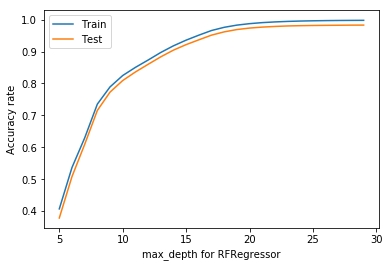

In [66]:
#creating a dummy list
list1= list(range(5, 30))
#plotting the learning curve on basis of max depth
plt.plot(list1 , train_accuracy_list , label = "Train")
plt.plot(list1 , test_accuracy_list, label = "Test")
plt.legend(loc = 'upperleft')
plt.xlabel("max_depth for RFRegressor")
plt.ylabel("Accuracy rate")
plt.show()
#plt.plot(list1 , train_accuracy_list)

### INFERENCE
#### The plot shows that the score of the model increases with increasing depth. At depth = 30, we get max score for both training and testing data.
#### It fits perfectly for both training and testing data(low bias and low variance).

In [67]:
#evaluating the model on varying basis of max depth of RandomForestRegressor
train_accuracy_list2 = []
test_accuracy_list2 = []

for i in range(5,30):
    regr = RandomForestRegressor(max_depth=i, random_state=0,n_estimators=100)
    regr.fit(x, y)
    y13_predict = regr.predict(x)
    print("Training error for depth = ", i , " : " ,sqrt(metrics.mean_squared_error(y, y13_predict)) ) #Random forest regressor
    train_accuracy_list2.append( sqrt(metrics.mean_squared_error(y, y13_predict)))
    y11_predict = regr.predict(x1)
    print("Testing error for depth = ", i , " : ",sqrt(metrics.mean_squared_error(y1, y11_predict)) ) #Random forest regressor
    test_accuracy_list2.append( sqrt(metrics.mean_squared_error(y1, y11_predict)))

print(len(train_accuracy_list2))
print(len(test_accuracy_list2))

#plt.plot()

Training error for depth =  5  :  207653.66612501928
Testing error for depth =  5  :  210662.566299494
Training error for depth =  6  :  183585.77703763332
Testing error for depth =  6  :  187407.1739120028
Training error for depth =  7  :  164214.924664939
Testing error for depth =  7  :  167111.04494928784
Training error for depth =  8  :  138770.70180603827
Testing error for depth =  8  :  142559.01139543066
Training error for depth =  9  :  123839.2822830247
Testing error for depth =  9  :  127379.40225141586
Training error for depth =  10  :  112883.24982379534
Testing error for depth =  10  :  116760.42274956865
Training error for depth =  11  :  104348.02596733403
Testing error for depth =  11  :  108263.29785123814
Training error for depth =  12  :  96027.34381451132
Testing error for depth =  12  :  100045.85778299741
Training error for depth =  13  :  86554.33416877079
Testing error for depth =  13  :  91282.31552953066
Training error for depth =  14  :  77306.21913813798
Tes

C:\Users\Ganesh\Anaconda4\lib\site-packages\matplotlib\legend.py:641: UserWarning: Unrecognized location "upperleft". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


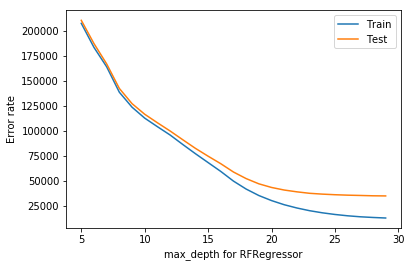

In [68]:
#plotting the bias variance curve on basis of max depth for randomforestregressor
plt.plot(list1 , train_accuracy_list2 , label = "Train")
plt.plot(list1 , test_accuracy_list2, label = "Test")
plt.legend(loc = 'upperleft')
plt.xlabel("max_depth for RFRegressor")
plt.ylabel("Error rate")
plt.show()

### INFERENCE
#### The plot shows that the error of the model decreases with increasing depth. At depth = 30, we get min error for both training and testing data.
#### It fits perfectly for both training and testing data(low bias and low variance).

In [71]:
#evalutaing model on basis of varying depth of ExtraTreesRegressor
train_accuracy_list2 = []
test_accuracy_list2 = []

for i in range(5,30):
    regr = sklearn.ensemble.ExtraTreesRegressor(n_estimators=500, max_depth=i)
    regr.fit(x, y)
    y13_predict = regr.predict(x)
    print("Training error for depth = ", i , " : " ,sqrt(metrics.mean_squared_error(y, y13_predict))) #Random forest regressor
    train_accuracy_list2.append( sqrt(metrics.mean_squared_error(y, y13_predict)))
    y11_predict = regr.predict(x1)
    print("Testing error for depth = ", i , " : ",sqrt(metrics.mean_squared_error(y1, y11_predict))) #Random forest regressor
    test_accuracy_list2.append( sqrt(metrics.mean_squared_error(y1, y11_predict)))

print(len(train_accuracy_list2))
print(len(test_accuracy_list2))

#plt.plot()

Training error for depth =  5  :  235350.26845773726
Testing error for depth =  5  :  234541.43312001097
Training error for depth =  6  :  220077.33839690406
Testing error for depth =  6  :  220033.17824766645
Training error for depth =  7  :  198689.05428222095
Testing error for depth =  7  :  199423.6895027931
Training error for depth =  8  :  176270.62801256264
Testing error for depth =  8  :  178125.23058136518
Training error for depth =  9  :  153612.8092284997
Testing error for depth =  9  :  156071.8598283448
Training error for depth =  10  :  133357.34954284763
Testing error for depth =  10  :  135970.6768440143
Training error for depth =  11  :  119289.50613627737
Testing error for depth =  11  :  121874.25475058351
Training error for depth =  12  :  107960.78840579747
Testing error for depth =  12  :  110586.20539141464
Training error for depth =  13  :  98633.16864380041
Testing error for depth =  13  :  101418.69310496231
Training error for depth =  14  :  89672.67645695577

C:\Users\Ganesh\Anaconda4\lib\site-packages\matplotlib\legend.py:641: UserWarning: Unrecognized location "upperleft". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


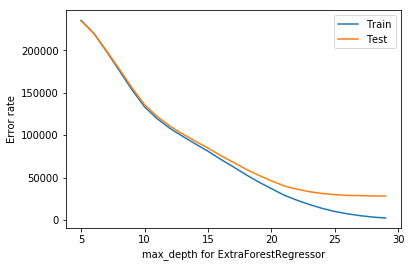

In [72]:
#plotting the bias variance curve on basis of max depth for extratreesregressor
plt.plot(list1 , train_accuracy_list2 , label = "Train")
plt.plot(list1 , test_accuracy_list2, label = "Test")
plt.legend(loc = 'upperleft')
plt.xlabel("max_depth for ExtraForestRegressor")
plt.ylabel("Error rate")
plt.show()

### INFERENCE
#### The plot shows that the error of the model decresases with increasing depth. At depth = 30, we get min error for both training and testing data.
#### It fits perfectly for both training and testing data(low bias and low variance).

In [77]:
#performing kfold cross validation for randomforestregressor on max depth =10
k_fold = KFold(len(y), n_folds=10, shuffle=True, random_state=0)
clf = RandomForestRegressor(max_depth=10, random_state=0,n_estimators=100)
print (cross_val_score(clf, x, y, cv=k_fold, n_jobs=1))

[ 0.80245452  0.8236552   0.81554744  0.82968571  0.8154178   0.8034798
  0.81990287  0.82936671  0.81724043  0.82739965]


In [76]:
#performing kfold cross validation for randomforestregressor max depth =30
k_fold = KFold(len(y), n_folds=10, shuffle=True, random_state=0)
clf = RandomForestRegressor(max_depth=30, random_state=0,n_estimators=100)
print (cross_val_score(clf, x, y, cv=k_fold, n_jobs=1))

[ 0.9858009   0.98518414  0.98625707  0.98478637  0.98591634  0.98709205
  0.98651876  0.98654913  0.98658212  0.9823055 ]


In [78]:
#performing kfold cross validation ExtraTreesRegressor on max depth =30
k_fold = KFold(len(y), n_folds=10, shuffle=True, random_state=0)
clf = sklearn.ensemble.ExtraTreesRegressor(n_estimators=500, max_depth=30)
print (cross_val_score(clf, x, y, cv=k_fold, n_jobs=1))

[ 0.98672592  0.98848964  0.98792732  0.98781275  0.98779115  0.9883634
  0.98808681  0.98837912  0.98776692  0.98820651]


### INFERENCE
#### The cross validation results give postive and expected results.

In [80]:
#Creating dummy lists 
train_accuracy_list3 = []
test_accuracy_list3 = []
inc3 = []
#defining a funtion to plot bias variance curve.
def BVCurve():
    minimum = 10000
    inc = int(x.shape[0]/5)
    maximum = x.shape[0]
    regr = RandomForestRegressor(max_depth=30, random_state=0,n_estimators=100)
    for i in range(minimum, maximum, inc):
        regr.fit(x[0:i], y[0:i])
        y13_predict = regr.predict(x[0:i])
        print(len(x[0:i]), len(y[0:i]), len(y13_predict))
        print("Training error for data of size = ", i , " : " ,sqrt(metrics.mean_squared_error(y[0:i], y13_predict)) ) #Random forest regressor
        train_accuracy_list2.append( sqrt(metrics.mean_squared_error(y[0:i], y13_predict)))
        y11_predict = regr.predict(x1[0:i])
        print("Testing error for data of size = ", i , " : ",sqrt(metrics.mean_squared_error(y1[0:i], y11_predict)) ) #Random forest regressor
        test_accuracy_list2.append( sqrt(metrics.mean_squared_error(y1[0:i], y11_predict)))
        inc3.append(i)


BVCurve()
print(len(train_accuracy_list3))
print(len(test_accuracy_list3))
print(len(inc3))

10000 10000 10000
Training error for data of size =  10000  :  70645.65799041465
Testing error for data of size =  10000  :  201542.94200717477
96990 96990 96990
Training error for data of size =  96990  :  28148.3231913324
Testing error for data of size =  96990  :  80491.34852460232
183980 183980 183980
Training error for data of size =  183980  :  18450.959878116213
Testing error for data of size =  183980  :  49298.52456789625
270970 270970 270970
Training error for data of size =  270970  :  14740.18373657365
Testing error for data of size =  270970  :  37586.81114497675
357960 357960 357960
Training error for data of size =  357960  :  13921.37060582735
Testing error for data of size =  357960  :  39253.80017244209
0
0
5


C:\Users\Ganesh\Anaconda4\lib\site-packages\matplotlib\legend.py:641: UserWarning: Unrecognized location "upperleft". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


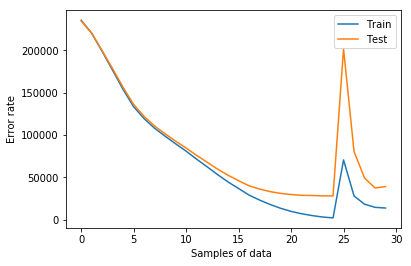

In [82]:
#plotting bias variance curve for RandomForestRegressor on varying samples of data
inr=list(range(30))
plt.plot(inr , train_accuracy_list2 , label = "Train")
plt.plot(inr , test_accuracy_list2, label = "Test")
plt.legend(loc = 'upperleft')
plt.xlabel("Samples of data ")
plt.ylabel("Error rate")
plt.show()

### CONCLUSIONS:
#### The meta data had important attributes that played important role.
#### The only attribute with missing values was the  temperature; it was first filled via groupby and later with machine learning.
####  The ensembe methods fit best than the linear models because of the non linear property of data.
#### The randomforestregressor and extratreesregressor gave score of 98.27 and 98.9 respectively and were better among all other ensemble techniques
#### The learning curves fit(neither underfit not overfit) well for both training and testing for both the models mentioned above.
#### The extratreesregressor would be used for prediction because of the accuracy and the fit over the validation curves.